# Credit Card Fraud Classification with a simple Wide and Deep Neural Network architecture, using TensorFlow, Keras and Talos.


<br>
<div style="text-align: justify">
This piece of work illustrates how to build a simple wide & deep neural network and make classification on credit card fraud dataset from [Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). The dataset contains transactions over a two-days period in September 2013.<br>    
    
The Wide & Deep neural network architecture, introduced by [Heng-Tze Cheng et al](https://dl.acm.org/doi/pdf/10.1145/2988450.2988454), connects all or part of the inputs directly to the output layer; hence makes it possible for the neural network to learn both deep patterns (using the deep path) and simple rules (through the short path).<br>

Just like performing a Grid-/Random-Search with Scikit-Learn, a set of hyperparameters will be optimized using Talos.
</div>


In [1]:
#we will try to build a reproductible experience, although without 
#guarantee, due to the extremely random nature of Neural Networks
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from sklearn.utils import class_weight
from sklearn.metrics import make_scorer

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier

# Importing the Keras libraries and packages from TensorFlow
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.losses import binary_crossentropy, logcosh
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.models import model_from_json
import tensorflow as tf

import talos
from talos import scan, Evaluate, Reporting 
from talos.utils import early_stopper, lr_normalizer
from talos.utils.gpu_utils import parallel_gpu_jobs
from talos.utils.recover_best_model import recover_best_model

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

data = pd.read_csv("/home/moukouba/data_science/python/datasets/creditcard.csv")

Using TensorFlow backend.


In [2]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data.shape

(284807, 31)

In [4]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [5]:
#We drop the Time column. It could be important, but we'll avoid the underlying preprocessing headache
df = data.drop('Time', axis=1)

In [6]:
#Separate the attributes (X) with the target variable (y)
X, y = df.iloc[:,:-1], data['Class']

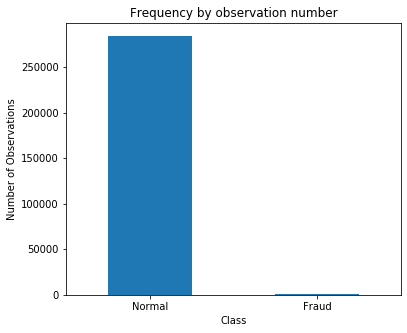

In [7]:
#Check for the class balance by plotting the frequency histogram
count_classes = pd.value_counts(y, sort = True)
labels = ["Normal","Fraud"]

count_classes.plot(kind = 'bar', rot=0, figsize=(6, 5))
plt.xticks(range(2), labels)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [8]:
dict(count_classes)

{0: 284315, 1: 492}

We have a case of highly imbalanced classes. As it will be shown later, the case will be dealt with using a penalized classifier (a.k.a Cost Sensitive Classifier).

In [9]:
#Checking for missing values
X.isnull().sum()

V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
dtype: int64

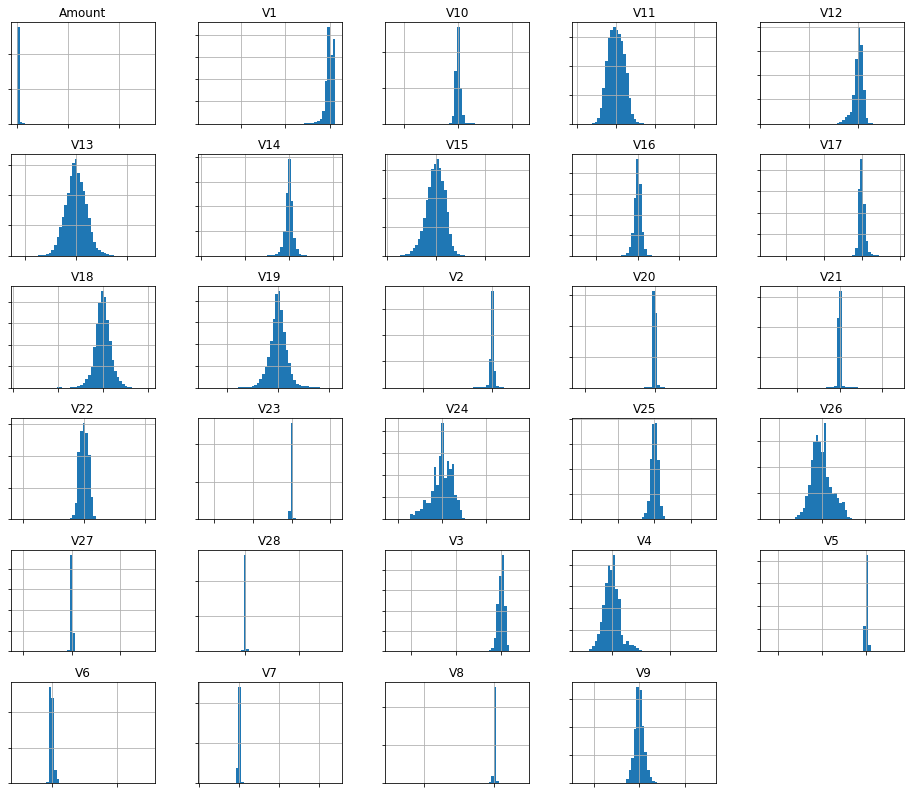

In [10]:
# create a histogram plot for each attribute
ax = X.hist(bins=50, figsize=(16, 14))
# disable axis labels to avoid the clutter
for axis in ax.flatten():
    axis.set_xticklabels([])
    axis.set_yticklabels([])
# show the plot
plt.show()

<div style="text-align: justify">
The above histograms show that, some features are near-normally distributed, some are skewed and so on. Since these are PCA-derived features and we do not have further information on the original data, we will avoid diving into, somehow, time consuming and cumbersome feature engineering and complicated data preprocessing, keeping in mind that, the problem at hand being an anomaly detection problem, any inconsistency in the data, such as outliers, might be of a valuable importance and could necessitate keeping them for better performance of the model.
</div>

<div style="text-align: justify"> 
For the sake of simplicity but also, as it will be seen, without impinging that much on the performance of the model, only features whose importance is greater than or equal to the median (based on importance weights) will be kept. We ended up with 15 best features, as shown below.
   
This can be implemented straightforwardly using the "feature_selection" module from scikit-learn. We will be using ExtraTreesClassifier as estimator.
</div>

In [11]:
selector = SelectFromModel(estimator=ExtraTreesClassifier(n_estimators=500, n_jobs=-1),
                           threshold='median').fit(X, y)
indices = selector.get_support(indices=True)
X_selected = X.iloc[:, indices]
X_selected

,V2,V3,V4,V7,V9,V10,V11,V12,V14,V16,V17,V18,V19,V21,V26
0,-0.072781,2.536347,1.378155,0.239599,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,-0.018307,-0.189115
1,0.266151,0.166480,0.448154,-0.078803,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.225775,0.125895
2,-1.340163,1.773209,0.379780,0.791461,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,0.247998,-0.139097
3,-0.185226,1.792993,-0.863291,0.237609,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,-0.108300,-0.221929
4,0.877737,1.548718,0.403034,0.592941,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,-0.009431,0.502292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,10.071785,-9.834783,-2.066656,-4.918215,1.914428,4.356170,-1.593105,2.711941,4.626942,1.107641,1.991691,0.510632,-0.682920,0.213454,0.250034
284803,-0.055080,2.035030,-0.738589,0.024330,0.584800,-0.975926,-0.150189,0.915802,-0.675143,-0.711757,-0.025693,-1.221179,-1.545556,0.214205,-0.395255
284804,-0.301254,-3.249640,-0.557828,-0.296827,0.432454,-0.484782,0.411614,0.063119,-0.510602,0.140716,0.313502,0.395652,-0.577252,0.232045,-0.087371
284805,0.530483,0.702510,0.689799,-0.686180,0.392087,-0.399126,-1.933849,-0.962886,0.449624,-0.608577,0.509928,1.113981,2.897849,0.265245,0.546668


<div style="text-align: justify">
Now, we can split the data into train and test sets, and Min-Max scale it to $0 - 1$ range, using train_test_split and MinMaxScaler, respectively.
</div>

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size = 0.3, random_state=42, stratify=y)

In [13]:
b_scaled = X_train.copy()
b_scaled_test = X_test.copy()

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(b_scaled)
scaled_test = scaler.transform(b_scaled_test)

x_train = scaled_train
x_test = scaled_test

x_train.shape

(199364, 15)

In [14]:
# deriving the class weights for cost sensitive classification
class_weights = np.around(class_weight.compute_class_weight('balanced', np.unique(y), y), 1)
class_weights = dict(enumerate(class_weights))
class_weights

{0: 0.5, 1: 289.4}

In [25]:
# Setting the dictionary of the hyperparameter to be included in the optimisation process 
p = {'neurons1': [8, 16, 32, 64, 128],
     'neurons2': [8, 16, 32, 64, 128],
     'batch_size': [16, 32, 64, 128, 512, 1024, 2048, 4096],
     'epochs': (10, 50, 5),
     'dropout1': (0.1, 0.6, 5),
     'dropout2': (0.1, 0.6, 5),
     'optimizer': ['Adam', 'RMSprop', 'SGD'],
     'losses': [logcosh, binary_crossentropy],
     'activation1':[relu, sigmoid],
     'activation2':[relu, sigmoid]}

<div style="text-align: justify">
Now, we build a basic wide & deep neural network, with two dropout-regularized hidden layers and one concatenate layer. It is worth noting that two metrics, viz. the Area Under the ROC curve (ROC_AUC) and the Area Unde Precision-Recall Curve (PR_AUC) will be used. This makes the process very costly computationally though, it was important as to check for the best metric between the two.
</div>

In [26]:
def model_builder(x_train, y_train, x_val, y_val, params):
    
    tf.keras.backend.clear_session()

    input_layer = tf.keras.layers.Input(shape=(15,))

    hidden_layer1 = Dense(params['neurons1'], kernel_initializer='uniform', 
                          activation=params['activation1'], use_bias=True)(input_layer)
    drop_out1 = Dropout(params['dropout1'])(hidden_layer1)
        
    hidden_layer2 = Dense(params['neurons2'], kernel_initializer='uniform', 
                          activation=params['activation2'], use_bias=True)(drop_out1)
    drop_out2 = Dropout(params['dropout2'])(hidden_layer2)

    concatenated = tf.keras.layers.Concatenate()([input_layer, drop_out2])
   
    output = Dense(1, activation='sigmoid')(concatenated)
            
    model = Model(inputs=[input_layer], outputs=[output])

    model.compile(optimizer=params['optimizer'], loss=params['losses'], 
                  metrics=[tf.keras.metrics.AUC(curve='PR', name='PR_AUC')])

    history = model.fit(x_train, y_train, batch_size=params['batch_size'],
                    epochs=params['epochs'], verbose=0, validation_data=[x_val, y_val],
                    callbacks=[early_stopper(epochs=params['epochs'], mode='moderate', monitor='val_loss')])

    return history, model

<div style="text-align: justify">
The next step is to run the experiments creating a Scan object - which we called "scrutinizer" - and split the GPU memory in two for two parallel jobs. Note that, the Scan object may hold many more parameters, like saving the weights of every single model in a folder created by experiment_name='folder_name' (here 'fraud_classification'). <br><br>
Moreover, the "fraction_limit" parameter sets the fraction of grid random sampling. Here, we can see that only 0.5% of all the possible combinations was used - that is, 3000 rounds - and the process took 93:41:09 to execute, on a modest GTX-1050 GPU.
</div>

In [ ]:
parallel_gpu_jobs(0.5)

scrutinizer = talos.Scan(x=x_train, y=y_train, x_val=x_test, y_val=y_test, seed=42, 
                         model=model_builder, experiment_name='fraud_classification', 
                         params=p, fraction_limit=0.05, reduction_metric='val_loss')





  0%|          | 0/30000 [00:00<?, ?it/s]



  0%|          | 1/30000 [00:31<263:05:55, 31.57s/it]



  0%|          | 2/30000 [00:40<206:39:29, 24.80s/it]



  0%|          | 3/30000 [00:49<168:07:56, 20.18s/it]



  0%|          | 4/30000 [01:34<229:39:24, 27.56s/it]



  0%|          | 5/30000 [02:18<270:23:03, 32.45s/it]



  0%|          | 6/30000 [02:27<212:15:00, 25.48s/it]



  0%|          | 7/30000 [03:09<253:41:27, 30.45s/it]



  0%|          | 8/30000 [03:51<282:06:55, 33.86s/it]



  0%|          | 9/30000 [05:05<381:07:54, 45.75s/it]



  0%|          | 10/30000 [08:17<747:21:31, 89.71s/it]



  0%|          | 11/30000 [08:44<589:44:56, 70.80s/it]



  0%|          | 12/30000 [09:22<508:07:23, 61.00s/it]



  0%|          | 13/30000 [09:58<446:44:33, 53.63s/it]



  0%|          | 14/30000 [12:45<730:17:43, 87.68s/it]



  0%|          | 15/30000 [13:16<588:32:51, 70.66s/it]



  0%|          | 16/30000 [17:11<998:28:48, 119.88s/it]



  0%|          | 17/30000 [17:3

  0%|          | 114/30000 [1:58:38<289:03:37, 34.82s/it]



  0%|          | 115/30000 [1:59:51<383:03:45, 46.14s/it]



  0%|          | 116/30000 [2:00:22<345:06:35, 41.57s/it]



  0%|          | 117/30000 [2:00:28<257:25:12, 31.01s/it]



  0%|          | 118/30000 [2:01:03<266:02:04, 32.05s/it]



  0%|          | 119/30000 [2:02:19<375:34:46, 45.25s/it]



  0%|          | 120/30000 [2:04:29<587:10:31, 70.74s/it]



  0%|          | 121/30000 [2:04:58<483:49:17, 58.29s/it]



  0%|          | 122/30000 [2:05:27<410:05:52, 49.41s/it]



  0%|          | 123/30000 [2:07:31<595:44:06, 71.78s/it]



  0%|          | 124/30000 [2:09:07<656:28:19, 79.10s/it]



  0%|          | 125/30000 [2:18:29<1858:49:18, 223.99s/it]



  0%|          | 126/30000 [2:18:49<1351:14:31, 162.83s/it]



  0%|          | 127/30000 [2:19:01<973:57:41, 117.37s/it] 



  0%|          | 128/30000 [2:19:12<711:26:23, 85.74s/it] 



  0%|          | 129/30000 [2:19:16<507:05:05, 61.11s/it]



  0%|          | 

  1%|          | 225/30000 [3:51:17<182:27:39, 22.06s/it]



  1%|          | 226/30000 [3:52:15<271:50:45, 32.87s/it]



  1%|          | 227/30000 [3:52:53<285:38:58, 34.54s/it]



  1%|          | 228/30000 [3:54:25<426:24:56, 51.56s/it]



  1%|          | 229/30000 [3:54:34<321:53:02, 38.92s/it]



  1%|          | 230/30000 [3:54:46<255:58:54, 30.96s/it]



  1%|          | 231/30000 [3:55:04<221:44:37, 26.82s/it]



  1%|          | 232/30000 [3:55:38<241:43:34, 29.23s/it]



  1%|          | 233/30000 [3:55:49<195:50:25, 23.68s/it]



  1%|          | 234/30000 [3:56:37<255:54:42, 30.95s/it]



  1%|          | 235/30000 [3:57:19<284:04:09, 34.36s/it]



  1%|          | 236/30000 [3:57:54<283:24:30, 34.28s/it]



  1%|          | 237/30000 [3:58:34<298:22:50, 36.09s/it]



  1%|          | 238/30000 [4:02:47<837:21:29, 101.29s/it]



  1%|          | 239/30000 [4:03:19<665:15:51, 80.47s/it] 



  1%|          | 240/30000 [4:03:34<502:09:19, 60.74s/it]



  1%|          | 241/3

  1%|          | 336/30000 [5:50:40<664:59:53, 80.70s/it] 



  1%|          | 337/30000 [5:50:52<494:34:20, 60.02s/it]



  1%|          | 338/30000 [5:51:47<480:33:49, 58.32s/it]



  1%|          | 339/30000 [5:52:08<388:45:12, 47.18s/it]



  1%|          | 340/30000 [5:52:57<393:27:23, 47.76s/it]



  1%|          | 341/30000 [5:56:34<811:47:32, 98.54s/it]



  1%|          | 342/30000 [5:57:23<688:59:26, 83.63s/it]



  1%|          | 343/30000 [5:57:44<533:47:07, 64.80s/it]



  1%|          | 344/30000 [5:58:00<415:29:03, 50.44s/it]



  1%|          | 345/30000 [5:59:17<480:14:21, 58.30s/it]



  1%|          | 346/30000 [5:59:21<346:00:51, 42.01s/it]



  1%|          | 347/30000 [5:59:37<280:31:01, 34.06s/it]



  1%|          | 348/30000 [6:03:55<834:38:28, 101.33s/it]



  1%|          | 349/30000 [6:09:30<1411:52:29, 171.42s/it]



  1%|          | 350/30000 [6:09:50<1038:21:53, 126.07s/it]



  1%|          | 351/30000 [6:10:41<853:26:09, 103.62s/it] 



  1%|          |

In [20]:
scrutinizer.details

experiment_name        fraud_classification
random_method              uniform_mersenne
reduction_method                       None
reduction_interval                       50
reduction_window                         20
reduction_threshold                     0.2
reduction_metric                   val_loss
complete_time                06/18/20/21:12
x_shape                        (199364, 15)
y_shape                           (199364,)
dtype: object

In [21]:
analyze_object = talos.Analyze(scrutinizer)

In [22]:
analyze_object.data

,start,end,duration,round_epochs,loss,PR_AUC,ROC_AUC,val_loss,val_PR_AUC,val_ROC_AUC,activation1,activation2,batch_size,dropout1,dropout2,epochs,losses,neurons1,neurons2,optimizer
0,06/16/20-222513,06/16/20-222517,4.432257,3,0.319975,0.618890,0.951426,0.351958,0.666116,0.949967,<function relu at 0x7fdf812db440>,<function relu at 0x7fdf812db440>,512,0.1,0.1,10,<function binary_crossentropy at 0x7fdf83cefdd0>,16,16,RMSprop
1,06/16/20-222517,06/16/20-222636,78.779595,10,0.209784,0.024528,0.598258,0.000738,0.198770,0.614817,<function sigmoid at 0x7fdf812db560>,<function relu at 0x7fdf812db440>,32,0.5,0.5,46,<function logcosh at 0x7fdf83cefc20>,8,16,RMSprop
2,06/16/20-222636,06/16/20-222643,6.511553,5,0.027263,0.655795,0.963877,0.041742,0.641460,0.950710,<function relu at 0x7fdf812db440>,<function relu at 0x7fdf812db440>,1024,0.2,0.2,28,<function logcosh at 0x7fdf83cefc20>,16,128,RMSprop
3,06/16/20-222643,06/16/20-222753,70.069889,16,0.687313,0.585375,0.893098,0.008078,0.585896,0.844480,<function relu at 0x7fdf812db440>,<function sigmoid at 0x7fdf812db560>,64,0.4,0.2,82,<function binary_crossentropy at 0x7fdf83cefdd0>,16,128,RMSprop
4,06/16/20-222753,06/16/20-222759,5.770446,4,0.207484,0.680923,0.966346,0.317841,0.647213,0.953317,<function relu at 0x7fdf812db440>,<function relu at 0x7fdf812db440>,2048,0.3,0.1,10,<function binary_crossentropy at 0x7fdf83cefdd0>,128,128,Adam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,06/18/20-211032,06/18/20-211056,23.903631,17,0.082840,0.711889,0.941120,0.075667,0.677170,0.945121,<function sigmoid at 0x7fdf812db560>,<function relu at 0x7fdf812db440>,512,0.2,0.4,28,<function logcosh at 0x7fdf83cefc20>,8,128,SGD
2996,06/18/20-211056,06/18/20-211119,23.248734,30,0.039997,0.576389,0.942895,0.018376,0.639634,0.953808,<function relu at 0x7fdf812db440>,<function sigmoid at 0x7fdf812db560>,4096,0.5,0.1,46,<function logcosh at 0x7fdf83cefc20>,8,32,Adam
2997,06/18/20-211120,06/18/20-211146,26.821407,9,0.218776,0.632282,0.958900,0.184142,0.668516,0.953490,<function sigmoid at 0x7fdf812db560>,<function sigmoid at 0x7fdf812db560>,128,0.3,0.4,46,<function binary_crossentropy at 0x7fdf83cefdd0>,128,32,Adam
2998,06/18/20-211147,06/18/20-211211,24.333296,23,0.261923,0.583162,0.948714,0.162243,0.656942,0.952283,<function relu at 0x7fdf812db440>,<function sigmoid at 0x7fdf812db560>,2048,0.4,0.5,82,<function binary_crossentropy at 0x7fdf83cefdd0>,8,128,Adam


In [51]:
model_id

2535

In [ ]:
analyze_object.data[['val_PR_AUC']].max()

In [68]:
analyze_object.data.iloc[2530:2538]

,start,end,duration,round_epochs,loss,PR_AUC,ROC_AUC,val_loss,val_PR_AUC,val_ROC_AUC,activation1,activation2,batch_size,dropout1,dropout2,epochs,losses,neurons1,neurons2,optimizer
2530,06/18/20-141206,06/18/20-141235,29.151778,27,0.043485,0.616390,0.932847,0.009778,0.647972,0.947545,<function sigmoid at 0x7fdf812db560>,<function relu at 0x7fdf812db440>,1024,0.5,0.4,46,<function logcosh at 0x7fdf83cefc20>,64,16,RMSprop
2531,06/18/20-141236,06/18/20-141317,41.567949,3,0.052842,0.696690,0.951789,0.035240,0.663342,0.942218,<function relu at 0x7fdf812db440>,<function relu at 0x7fdf812db440>,16,0.3,0.5,10,<function logcosh at 0x7fdf83cefc20>,16,8,SGD
2532,06/18/20-141317,06/18/20-141404,47.056744,64,0.097832,0.398907,0.833106,0.086513,0.616302,0.918385,<function relu at 0x7fdf812db440>,<function sigmoid at 0x7fdf812db560>,4096,0.1,0.2,64,<function logcosh at 0x7fdf83cefc20>,16,8,SGD
2533,06/18/20-141405,06/18/20-141431,26.638915,21,0.031270,0.644633,0.952914,0.008231,0.659429,0.952283,<function sigmoid at 0x7fdf812db560>,<function relu at 0x7fdf812db440>,1024,0.1,0.3,64,<function logcosh at 0x7fdf83cefc20>,64,16,Adam
2534,06/18/20-141432,06/18/20-141448,16.517424,15,0.040396,0.553803,0.949060,0.015445,0.656906,0.954916,<function relu at 0x7fdf812db440>,<function relu at 0x7fdf812db440>,2048,0.5,0.3,46,<function logcosh at 0x7fdf83cefc20>,8,128,RMSprop
2535,06/18/20-141448,06/18/20-141554,65.781538,14,0.467740,0.614610,0.939192,0.006694,0.690909,0.932296,<function relu at 0x7fdf812db440>,<function sigmoid at 0x7fdf812db560>,64,0.1,0.1,82,<function binary_crossentropy at 0x7fdf83cefdd0>,128,32,RMSprop
2536,06/18/20-141554,06/18/20-141608,13.610839,5,0.408992,0.659282,0.927835,0.255550,0.670511,0.946443,<function sigmoid at 0x7fdf812db560>,<function relu at 0x7fdf812db440>,128,0.3,0.5,10,<function binary_crossentropy at 0x7fdf83cefdd0>,16,8,Adam
2537,06/18/20-141608,06/18/20-141619,10.600860,9,0.118828,0.002093,0.553024,0.114631,0.153523,0.794806,<function sigmoid at 0x7fdf812db560>,<function sigmoid at 0x7fdf812db560>,2048,0.2,0.1,46,<function logcosh at 0x7fdf83cefc20>,64,64,SGD


In [41]:
# The highest PR_AUC achieved on validation set 
analyze_object.high('val_PR_AUC')

0.6909090280532837

In [42]:
# The highest ROC_AUC achieved on validation set 
analyze_object.high('val_ROC_AUC')

0.9614167809486389

In [70]:
# The best model based on validation PR_AUC
best = scrutinizer.best_model(metric='val_PR_AUC', asc=False)

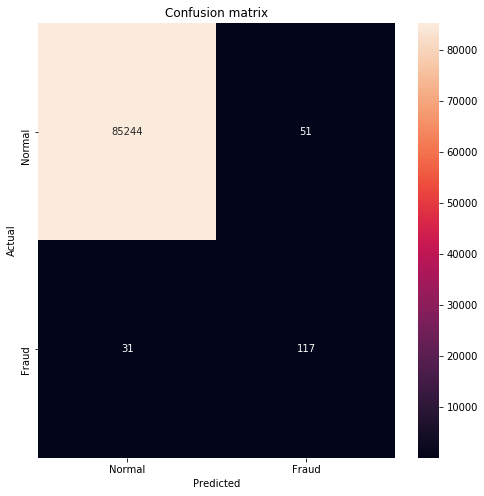

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.70      0.79      0.74       148

    accuracy                           1.00     85443
   macro avg       0.85      0.89      0.87     85443
weighted avg       1.00      1.00      1.00     85443



In [71]:
# Predicting the Test set results
y_pred = best.predict(x_test)
y_pred = (y_pred > 0.5)

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(y_test, y_pred))

In [72]:
# The best model based on validation ROC_AUC
best1 = scrutinizer.best_model(metric='val_ROC_AUC', asc=False)

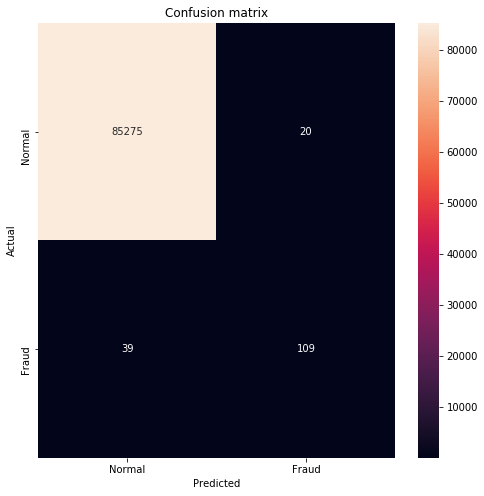

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.84      0.74      0.79       148

    accuracy                           1.00     85443
   macro avg       0.92      0.87      0.89     85443
weighted avg       1.00      1.00      1.00     85443



In [73]:
# Predicting the Test set results
y_pred1 = best1.predict(x_test)
y_pred1 = (y_pred1 > 0.5)

conf_matrix = confusion_matrix(y_test, y_pred1)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(classification_report(y_test, y_pred1))

In [65]:
# Get the best model index with highest 'val_categorical_accuracy' 
model_id = analyze_object.data[['val_ROC_AUC']].idxmax()[0]

# model_id = scan_results.data['val_categorical_accuracy'].astype('float').argmax() - 1

# Clear any previous TensorFlow session.
tf.keras.backend.clear_session()

# Load the model parameters from the scanner.
model = model_from_json(scrutinizer.saved_models[model_id])
model.set_weights(scrutinizer.saved_weights[model_id])
model.summary()
model.save('./best_model.h5')

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           1024        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 64)           0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 8)            520         dropout[0][0]                    
______________________________________________________________________________________________

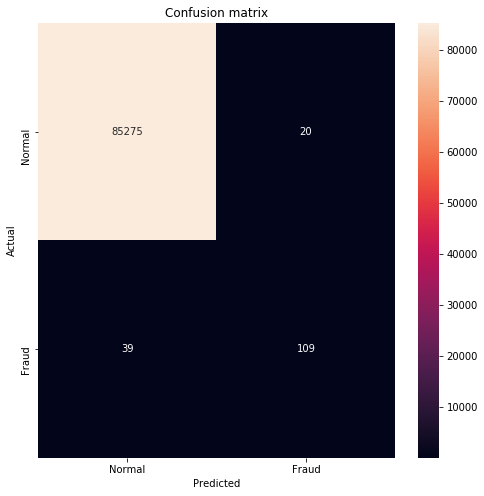

ROC AUC: 0.868
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.84      0.74      0.79       148

    accuracy                           1.00     85443
   macro avg       0.92      0.87      0.89     85443
weighted avg       1.00      1.00      1.00     85443



In [66]:
# Predicting the Test set results
y_pred2 = model.predict(x_test)
y_pred2 = (y_pred2 > 0.5)

conf_matrix = confusion_matrix(y_test, y_pred2)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

score = roc_auc_score(y_test, y_pred2)
print('ROC AUC: %.3f' % score)

print(classification_report(y_test, y_pred2))

<div style="text-align: justify">
As it can be noticed, Talos does not choose the best performing model necessarily as the one with the highest metric, but the one with the best combination of both loss and metric. Moreover, as could be expected for highly imbalanced classes, PR_AUC should be the preferred metric. The best model based on PR_AUC shows a ROC_AUC of $0.885$ (vs $0.892$ for the ROC_AUC based model), but is less prone to False Positives, keeping a good trade off between False Positives and False Negatives.<br><br>
Besides, it should be noted that, not only the process has the potential of yielding even better results, since only 0.5% of the parameter space was searched, but also we may improve the score by tweaking, say, the architecture of the network or adding more hyperparameters to be searched, at some expense.<br><br>
It's unfortunate that there is no specific command to pick the model with the highest metric, to see how it would perform, analyzing and comparing its confusion matrix to that of the best model. Although it is still possible to manually track the model with the highest performance through the "analyze_object" and its weights if saved during the scan process, but this is beyond the scope of this work. Talos offers a lot of interesting and easy-to-use functionalities like the "Reporting()" command which consists of access to several meaningful signals related with the experiment, together with the dataframe with results for each permutation, together with the corresponding hyperparameter  configurations. 
</div>